# Array geometry selection
Compares the performance of different array geometries (for max SINR and NormMUSIC algorithoms), via:

- SIR for two sources place a fixed distance apart (averaged across the entire stage)

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import colormaps
import pyroomacoustics as pra
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)
from scipy.io import wavfile
from playsound import playsound

Simulation parameters

In [2]:
# ROOM PARAMETERS
fs = 8000 # audio sampling frequency - global (set to freq of input file)

room_x = 10 # room width
room_y = 20 # room length
stage_x = [1, 9]
stage_y = [13, 17] # x/y bounds of stage in the room
order = 0 # reflection order
sigma2_n = 5e-7 # microphone noise variance estimate
source_step = 0.1 # resolution of simulation grid (m)

m = pra.make_materials(
    ceiling="hard_surface",
    floor="stage_floor",
    east="brickwork",
    west="brickwork",
    north="brickwork",
    south="brickwork",
) # materials of each surface of room, defines signal absorption when order is nonzero

# MIC ARRAY PARAMETERS
pattern = pra.DirectivityPattern.CARDIOID
orientation = pra.DirectionVector(azimuth=90, colatitude=None, degrees=True)
directivity = pra.CardioidFamily(orientation=orientation, pattern_enum=pattern)

dist_to_stage = 0.5 # design parameter for array y location
array_loc = [5, stage_y[0]-dist_to_stage] # x/y location of array - front and center of stage
n_mics = 8 # number of microphones

N = 1024 # fft length - defines N/2 + 1 frequency bands

# SOUND SOURCE PARAMETERS
source_x = np.arange(stage_x[0], stage_x[1]+source_step, source_step)
source_y = np.arange(stage_y[0], stage_y[1]+source_step, source_step) # Define spatial grid over which to simulate
source_filenames = ['../input_samples/singing_8000.wav', '../input_samples/german_speech_8000.wav']
_, singing = wavfile.read(source_filenames[0])
_, speech = wavfile.read(source_filenames[1])

### Linear Array

Test different separations.

Simulating Separation of 0.05 m ...


/opt/miniconda3/lib/python3.12/site-packages/pyroomacoustics/beamforming.py:888: RuntimeWarning: invalid value encountered in log10
  SNR = 10 * np.log10(SNR)


Separation (m):  0.05
Average SINR across stage (dB):  83.40571953082393
Maximum SINR across stage (dB):  107.50374402742955
Minimum SINR across stage (dB):  67.83696091501305
Simulating Separation of 0.1 m ...
Separation (m):  0.1
Average SINR across stage (dB):  90.25142428354049
Maximum SINR across stage (dB):  104.60866911778533
Minimum SINR across stage (dB):  76.76538636692817
Simulating Separation of 0.15000000000000002 m ...
Separation (m):  0.15000000000000002
Average SINR across stage (dB):  91.49299018905447
Maximum SINR across stage (dB):  107.81594194523204
Minimum SINR across stage (dB):  80.63930516394103
Simulating Separation of 0.2 m ...
Separation (m):  0.2
Average SINR across stage (dB):  90.68905380054103
Maximum SINR across stage (dB):  105.38689431034261
Minimum SINR across stage (dB):  82.6786816065599
Simulating Separation of 0.25 m ...
Separation (m):  0.25
Average SINR across stage (dB):  89.26480168816697
Maximum SINR across stage (dB):  104.56557928567689
Mi

RuntimeError: the rir array is too small for the maximum time recorded

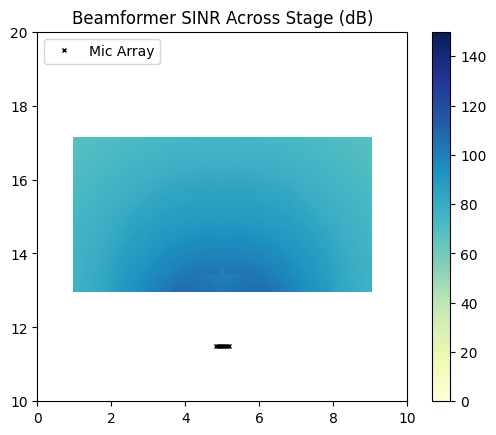

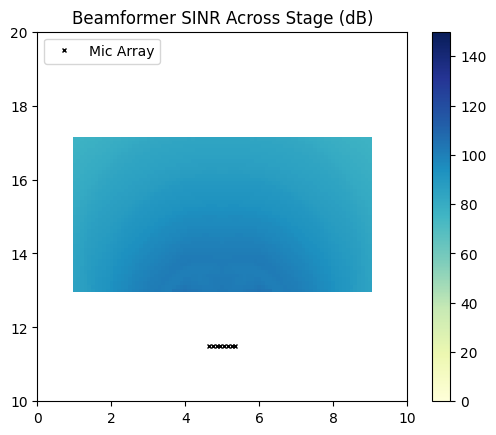

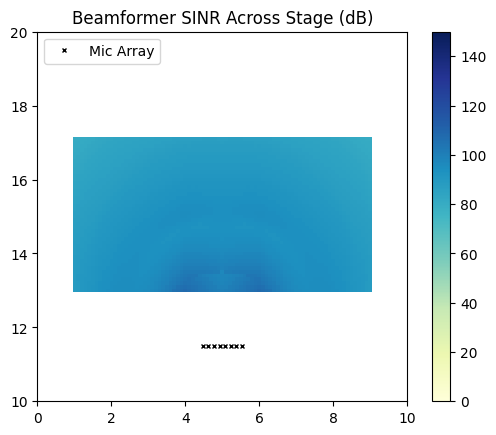

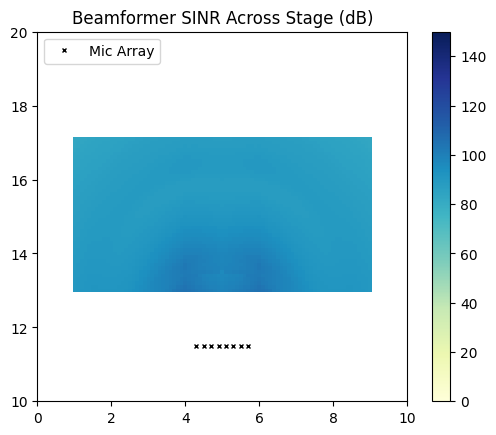

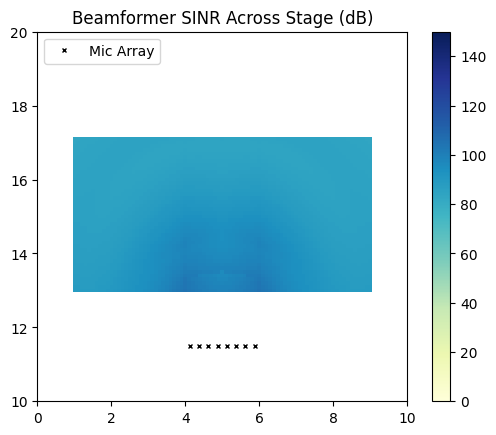

In [3]:
d = 2 # source separation parameter
sep = np.arange(0.05, 0.55, 0.05) # varying mic separations (increments of 5cm)

for s in sep:
    R = pra.linear_2D_array(center=array_loc, M=n_mics, phi=0, d=s)
    mic_array = pra.Beamformer(R, fs, N) # uses omnidirectional mics by default
    mic_array.set_directivity(directivities=directivity) # use cardioid microphones

    SIRs = np.empty(shape=(len(source_x),len(source_y)))
    print(f'Simulating Separation of {s} m ...')

    for i in range(len(source_x)):
        for j in range(len(source_y)):

            x = source_x[i]
            y = source_y[j]

            # build room, array, and sources
            room = pra.ShoeBox([room_x, room_y], fs=fs, materials=m, max_order=order, air_absorption=True, ray_tracing=False)
            room.add_microphone_array(mic_array)

            s1 = [x, y] # 1st source location
            s1_mic = [x - array_loc[0], y - array_loc[1]] # location relative to array
            r = math.sqrt(s1_mic[0]**2 + s1_mic[1]**2)

            if r >= d:
                phi_rad = 2 * math.asin(d/(2*r))

                if s1_mic[0] < 0:
                    phi_rad *= -1

                s2_mic = [s1_mic[0]*math.cos(phi_rad) - s1_mic[1]*math.sin(phi_rad), s1_mic[0]*math.sin(phi_rad) + s1_mic[1]*math.cos(phi_rad)] # 2nd source location relative to array
                s2 = [s2_mic[0] + array_loc[0], s2_mic[1] + array_loc[1]]
            else:
                if s1_mic[0] < 0:
                    multiplier = 1
                else:
                    multiplier = -1
                    
                s2 = [s1[0] + multiplier*d, s1[1]]

            source_locs = [s1, s2] # locations of each source
            room.add_source(source_locs[0], signal=singing, delay=0)
            room.add_source(source_locs[1], signal=speech, delay=0)

            # define beamformer algorithm and compute weights
            mic_array.rake_max_sinr_weights(
                source=room.sources[0][0:1],
                interferer=room.sources[1][0:1],
                R_n=sigma2_n * np.eye(mic_array.M)
            )
            mic_array.filters_from_weights()

            # run simulation
            room.compute_rir()
            room.simulate()

            # compute SIR, averaged across all frequency bands
            SIR_sum = 0
            for f in mic_array.frequencies:
                current_SIR = mic_array.snr(room.sources[0][0:1], room.sources[1][0:1], f, dB=True)
                if math.isnan(current_SIR) == False:
                    SIR_sum += current_SIR
            SIRs[i, j] = SIR_sum / len(mic_array.frequencies)

    # plot SIR as a function of location
    y, x = np.meshgrid(source_y, source_x)
    sir_min = np.min(SIRs)
    sir_max = np.max(SIRs)
    sir_avg = np.mean(SIRs)

    fig, ax = plt.subplots()
    c = ax.pcolormesh(x, y, SIRs, cmap='YlGnBu', vmin=0, vmax=150)
    ax.plot(mic_array.R[0], mic_array.R[1], 'kx', markersize=3, label="Mic Array")
    ax.set_title('Beamformer SINR Across Stage (dB)')
    ax.axis([0, room_x, room_y/2, room_y])
    fig.gca().set_aspect('equal', adjustable='box')
    fig.colorbar(c, ax=ax)
    plt.legend(loc="upper left")
    plt.savefig('separation_' + str(s) + '.png')

    # output SIR stats
    print("Separation (m): ", s)
    print("Average SINR across stage (dB): ", sir_avg)
    print("Maximum SINR across stage (dB): ", sir_max)
    print("Minimum SINR across stage (dB): ", sir_min)

### Semicircular Array

Test different radii.

In [10]:
# helper function to generate a semicircular array
def semicircular_2D_array(center, n_mics, r):

    # define microphone locations
    center = np.array(center)
    lower_left_corner = np.array([stage_x[0], stage_y[0]])
    corner_vec = lower_left_corner - center
    d_to_corner = np.linalg.norm(corner_vec)

    d_to_stage = stage_y[0] - array_loc[1]

    theta = np.arccos(d_to_stage / d_to_corner)
    angles = np.linspace(-theta, theta, n_mics)

    # define directivies
    pattern = pra.DirectivityPattern.CARDIOID

    Rx = []
    Ry = [] # coordinates of microphones
    directivities = [] # directivities of microphones
    for a in angles:
        Rx.append(r * np.sin(a) + center[0])
        Ry.append(r * np.cos(a) + center[1])

        orientation = pra.DirectionVector(azimuth=np.pi/2 - a, colatitude=None, degrees=False)
        directivity = pra.CardioidFamily(orientation=orientation, pattern_enum=pattern)
        directivities.append(directivity)

    R = [Rx, Ry]
    mic_array = pra.Beamformer(R, fs, N) # uses omnidirectional mics by default
    mic_array.set_directivity(directivities=directivities) # use cardioid microphones
    
    return mic_array

Simulating Radius of 0.5 m ...
Radius (m):  0.5
Average SINR across stage (dB):  87.43218714706335
Maximum SINR across stage (dB):  109.99674296020397
Minimum SINR across stage (dB):  74.29872394795557
Simulating Radius of 0.6 m ...
Radius (m):  0.6
Average SINR across stage (dB):  87.83823475188738
Maximum SINR across stage (dB):  112.60167052436401
Minimum SINR across stage (dB):  75.11102400782269
Simulating Radius of 0.7 m ...
Radius (m):  0.7
Average SINR across stage (dB):  88.36783501961538
Maximum SINR across stage (dB):  114.03833063887211
Minimum SINR across stage (dB):  75.86814957576573
Simulating Radius of 0.7999999999999999 m ...
Radius (m):  0.7999999999999999
Average SINR across stage (dB):  88.92633465061573
Maximum SINR across stage (dB):  114.38646329847136
Minimum SINR across stage (dB):  75.29351081017498
Simulating Radius of 0.8999999999999999 m ...
Radius (m):  0.8999999999999999
Average SINR across stage (dB):  89.4635649556329
Maximum SINR across stage (dB):  1

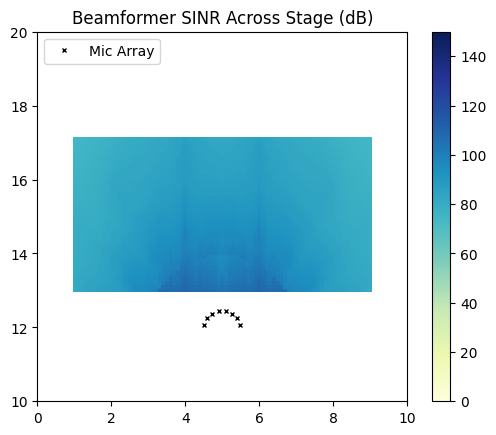

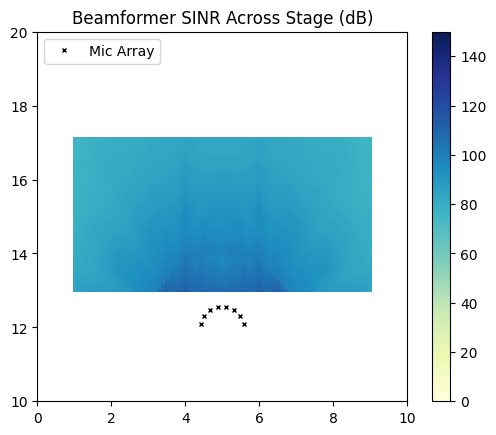

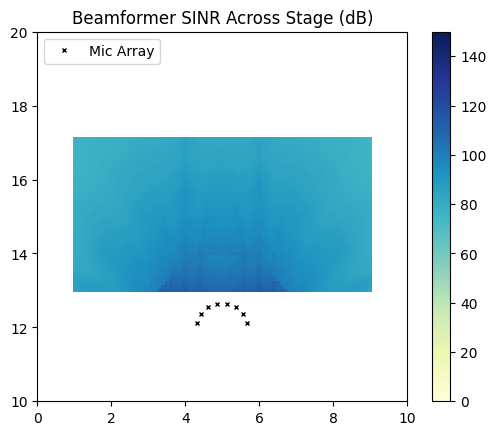

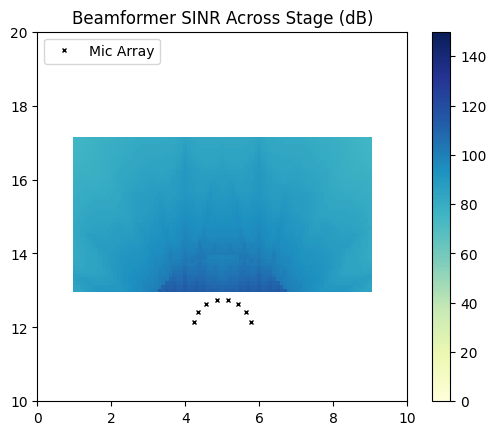

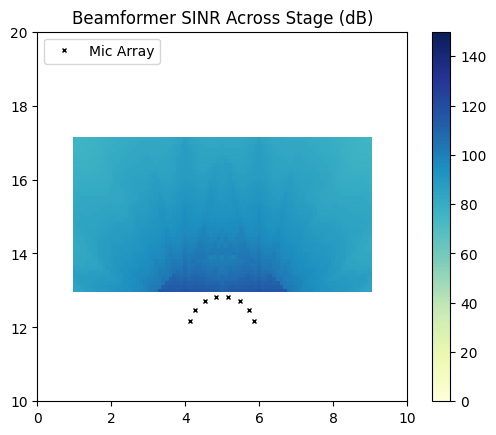

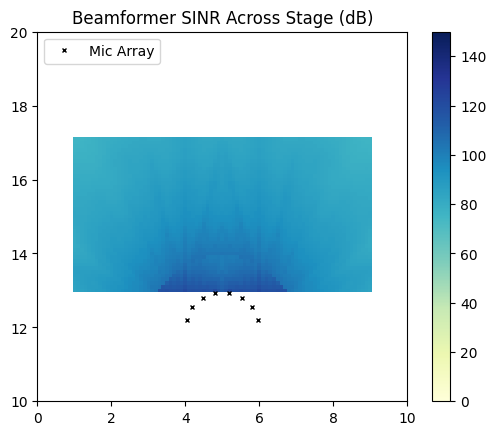

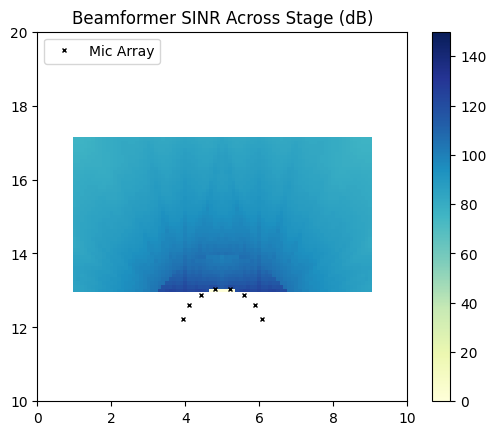

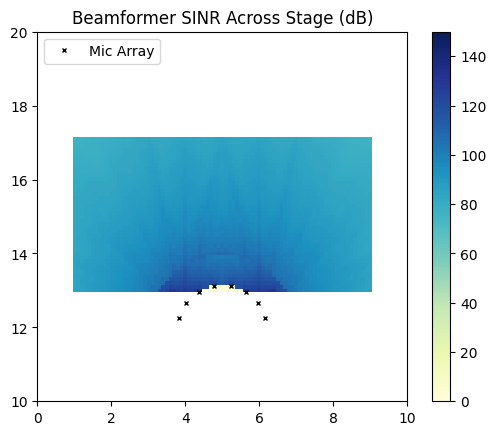

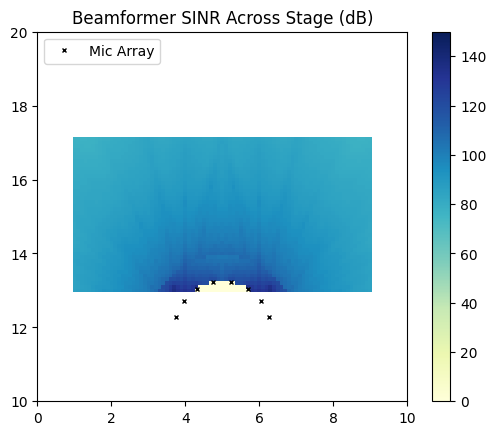

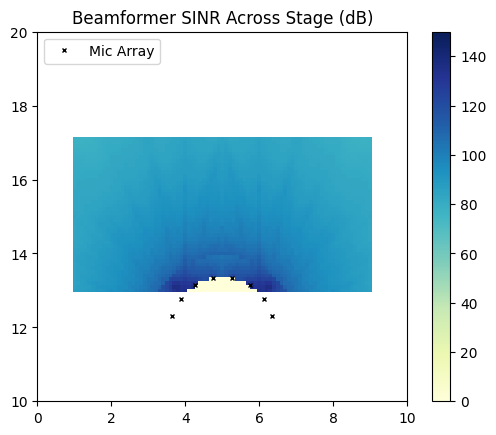

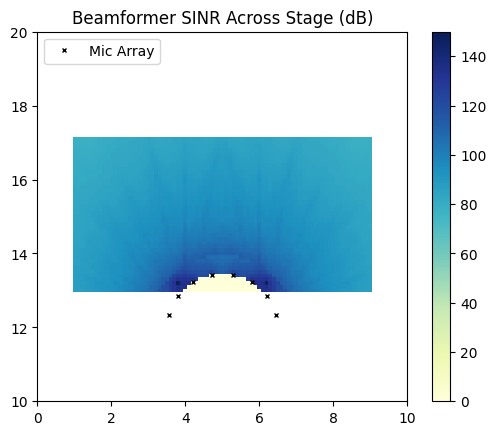

In [11]:
d = 2 # source separation parameter
radii = np.arange(0.5, 1.6, 0.1) # varying mic separations (increments of 10cm radii)

for rad in radii:
    mic_array = semicircular_2D_array(array_loc, n_mics, rad)

    SIRs = np.empty(shape=(len(source_x),len(source_y)))
    print(f'Simulating Radius of {rad} m ...')

    for i in range(len(source_x)):
        for j in range(len(source_y)):

            x = source_x[i]
            y = source_y[j]

            # build room, array, and sources
            room = pra.ShoeBox([room_x, room_y], fs=fs, materials=m, max_order=order, air_absorption=True, ray_tracing=False)
            room.add_microphone_array(mic_array)

            s1 = [x, y] # 1st source location
            s1_mic = [x - array_loc[0], y - array_loc[1]] # location relative to array
            r = math.sqrt(s1_mic[0]**2 + s1_mic[1]**2)

            if r <= rad:
                SIRs[i, j] = 0
            else:
                if r >= d:
                    phi_rad = 2 * math.asin(d/(2*r))

                    if s1_mic[0] < 0:
                        phi_rad *= -1

                    s2_mic = [s1_mic[0]*math.cos(phi_rad) - s1_mic[1]*math.sin(phi_rad), s1_mic[0]*math.sin(phi_rad) + s1_mic[1]*math.cos(phi_rad)] # 2nd source location relative to array
                    s2 = [s2_mic[0] + array_loc[0], s2_mic[1] + array_loc[1]]
                else:
                    if s1_mic[0] < 0:
                        multiplier = 1
                    else:
                        multiplier = -1
                        
                    s2 = [s1[0] + multiplier*d, s1[1]]

                source_locs = [s1, s2] # locations of each source
                room.add_source(source_locs[0], signal=singing, delay=0)
                room.add_source(source_locs[1], signal=speech, delay=0)

                # define beamformer algorithm and compute weights
                mic_array.rake_max_sinr_weights(
                    source=room.sources[0][0:1],
                    interferer=room.sources[1][0:1],
                    R_n=sigma2_n * np.eye(mic_array.M)
                )
                mic_array.filters_from_weights()

                # run simulation
                room.compute_rir()
                room.simulate()

                # compute SIR, averaged across all frequency bands
                SIR_sum = 0
                for f in mic_array.frequencies:
                    current_SIR = mic_array.snr(room.sources[0][0:1], room.sources[1][0:1], f, dB=True)
                    if math.isnan(current_SIR) == False:
                        SIR_sum += current_SIR
                SIRs[i, j] = SIR_sum / len(mic_array.frequencies)

    # plot SIR as a function of location
    y, x = np.meshgrid(source_y, source_x)
    sir_min = np.min(SIRs)
    sir_max = np.max(SIRs)
    sir_avg = np.mean(SIRs)

    fig, ax = plt.subplots()
    c = ax.pcolormesh(x, y, SIRs, cmap='YlGnBu', vmin=0, vmax=150)
    ax.plot(mic_array.R[0], mic_array.R[1], 'kx', markersize=3, label="Mic Array")
    ax.set_title('Beamformer SINR Across Stage (dB)')
    ax.axis([0, room_x, room_y/2, room_y])
    fig.gca().set_aspect('equal', adjustable='box')
    fig.colorbar(c, ax=ax)
    plt.legend(loc="upper left")
    plt.savefig('radius_' + str(rad) + '.png')

    # output SIR stats
    print("Radius (m): ", rad)
    print("Average SINR across stage (dB): ", sir_avg)
    print("Maximum SINR across stage (dB): ", sir_max)
    print("Minimum SINR across stage (dB): ", sir_min)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

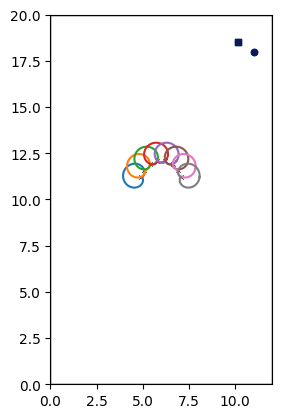

In [122]:
room.plot()